<a href="https://colab.research.google.com/github/SapateAtharva/Aerospace-Components-Export-Performance-Analysis/blob/main/Aerospace_Components_Export_Performance_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [228]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [229]:
# Define constants for data file path and years of interest
DATA_FILE = 'https://raw.githubusercontent.com/SapateAtharva/Aerospace-Components-Export-Performance-Analysis/main/aerospace_exports.csv'
START_YEAR = 2019
END_YEAR = 2023
FORECAST_YEARS = [2024, 2025]

In [230]:
def run_data_science_pipeline():
    """
    Main function to execute the full data science pipeline.
    """
    print("--- Starting Data Science Mini-Project ---")

    # Load and preprocess the data
    df = load_and_transform_data(DATA_FILE)
    # Exit if data loading failed
    if df is None:
        return

    print("\nData preprocessed successfully.")
    print("First 5 rows of data:")
    print(df.head())

    # Ensure 'Year' is numeric and aggregate data by year for EDA
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce').fillna(0).astype(int)
    df_agg_total = df.groupby('Year')['ExportValue_USD_Millions'].sum().reset_index()
    # Run Exploratory Data Analysis (EDA)
    run_eda(df, df_agg_total)
    print("EDA plots generated and saved to 'plots/' directory.")

    print("\n--- Starting Model Training & Evaluation ---")

    # Ensure 'Year' is numeric and aggregate data by year for modeling
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce').fillna(0).astype(int)
    df_agg = df.groupby('Year')['ExportValue_USD_Millions'].sum().reset_index()

    # Prepare training and testing data
    train_data = df_agg[df_agg['Year'] < END_YEAR]
    test_data = df_agg[df_agg['Year'] == END_YEAR]

    X_train = train_data[['Year']]
    y_train = train_data['ExportValue_USD_Millions']
    X_test = test_data[['Year']]
    y_test = test_data['ExportValue_USD_Millions']

    # Initialize and train the Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    print("Model trained successfully.")

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    print("\n--- Model Evaluation Results (on 2023 Test Data) ---")

    # Calculate and print evaluation metrics
    if len(y_test) >= 2:
        r2 = r2_score(y_test, y_pred)
        print(f"R-squared (R²): {r2:.4f}")
    else:
        print("R-squared (R²): Not applicable (test set has less than 2 samples)")

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"Mean Absolute Error (MAE): ${mae:.2f} Million")
    print(f"Root Mean Squared Error (RMSE): ${rmse:.2f} Million")

    print("\nActual vs. Predicted for 2023:")
    print(f"  Actual: ${y_test.values[0]:.2f} Million")
    print(f"  Predicted: ${y_pred[0]:.2f} Million")

    print("\n--- Generating Final Forecast Plot ---")
    # Generate and save the forecast plot
    generate_forecast_plot(model, df_agg)
    print("Forecast plot saved to 'plots/final_forecast_plot.png'")

    print("\n--- Data Science Mini-Project Completed ---")

In [231]:
def load_and_transform_data(filepath):
    """
    Loads, cleans, and transforms the initial dataset.
    """
    print(f"1. [ETL] Extracting data from '{filepath}'...")
    try:
        df = pd.read_csv(filepath, sep=',', engine='python', dtype={'Year_Quarter': str})
        print("Initial DataFrame head:")
        display(df.head())
    except FileNotFoundError:
        print(f"Error: Data file '{filepath}' not found.")
        return None
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return None


    print("2. [ETL] Transforming data...")
    print("DataFrame columns before cleaning 'Year':", df.columns)
    df['Year'] = df['Year_Quarter'].str.split('-').str[0]
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    df.dropna(subset=['Year'], inplace=True)
    df['Year'] = df['Year'].astype(int)

    df['ExportValue_USD_Millions'] = pd.to_numeric(df['ExportValue_USD_Millions'], errors='coerce')
    df['Gov_Incentive_Millions'] = pd.to_numeric(df['Gov_Incentive_Millions'], errors='coerce')


    print("DataFrame head after cleaning 'Year' column:")
    display(df.head())

    if df.isnull().sum().sum() > 0:
        print("Warning: Missing values detected. Filling with 0 for this demo.")
        df.fillna(0, inplace=True)
        print("DataFrame head after filling missing values:")
        display(df.head())


    print("3. [ETL] Loading data into DataFrame.")
    return df

In [232]:
def run_eda(df, df_agg_total):
    """
    Generates and saves all EDA plots.
    """
    import os
    # Create a directory to save plots if it doesn't exist
    if not os.path.exists('plots'):
        os.makedirs('plots')

    # Use a seaborn style for plots
    plt.style.use('seaborn-v0_8-darkgrid')

    # Ensure 'Year' column is numeric and handle potential errors
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    # Drop rows where 'Year' could not be converted to a number
    df.dropna(subset=['Year'], inplace=True)
    # Convert 'Year' to integer type
    df['Year'] = df['Year'].astype(int)

    # Print data type of 'Year' for debugging
    print("Data type of 'Year' in run_eda after explicit conversion:", df['Year'].dtype)

    print("\n--- Plot 1: Total Export Trend Over Time ---")
    # Print data types for Plot 1 for debugging
    print("Data types for Plot 1:", df_agg_total[['Year', 'ExportValue_USD_Millions']].dtypes)
    # Create a new figure and axes for the plot
    plt.figure(figsize=(10, 6))
    # Generate a line plot of total export value over time
    sns.lineplot(x=df_agg_total['Year'], y=df_agg_total['ExportValue_USD_Millions'], marker='o', lw=3)
    # Set the title of the plot
    plt.title('Total Aerospace Exports from India (2019-2023)', fontsize=16)
    # Set the label for the x-axis
    plt.xlabel('Year', fontsize=12)
    # Set the label for the y-axis
    plt.ylabel('Total Export Value (USD Millions)', fontsize=12)
    # Set the x-axis ticks to be the years from START_YEAR to END_YEAR
    plt.xticks(range(START_YEAR, END_YEAR + 1))
    # Save the plot to a file
    plt.savefig('plots/total_export_trend.png')
    # Display the plot
    plt.show()
    # Close the plot figure
    plt.close()

    print("\n--- Plot 2: Export Value by Component (Total) ---")
    # Group data by Component and sum ExportValue_USD_Millions, then sort
    df_agg_comp = df.groupby('Component')['ExportValue_USD_Millions'].sum().sort_values(ascending=False)
    # Print data types for Plot 2 for debugging
    print("Data types for Plot 2:", df_agg_comp.dtypes)
    # Create a new figure and axes for the plot
    plt.figure(figsize=(10, 6))
    # Generate a bar plot of total export value by component
    sns.barplot(x=df_agg_comp.values, y=df_agg_comp.index, palette='viridis', hue=df_agg_comp.index, legend=False)
    # Set the title of the plot
    plt.title('Total Export Value by Component (2019-2023)', fontsize=16)
    # Set the label for the x-axis
    plt.xlabel('Total Export Value (USD Millions)', fontsize=12)
    # Set the label for the y-axis
    plt.ylabel('Component', fontsize=12)
    # Save the plot to a file
    plt.savefig('plots/component_total_exports.png')
    # Display the plot
    plt.show()
    # Close the plot figure
    plt.close()

    print("\n--- Plot 3: Component Export Trends Over Time ---")
    # Print data types for Plot 3 for debugging
    print("Data types for Plot 3:", df[['Year', 'ExportValue_USD_Millions', 'Component']].dtypes)
    # Create a new figure and axes for the plot
    plt.figure(figsize=(12, 7))
    # Generate a line plot showing export trends for each component over time
    sns.lineplot(data=df, x='Year', y='ExportValue_USD_Millions', hue='Component', marker='o', lw=2.5)
    # Set the title of the plot
    plt.title('Component-wise Export Trends (2019-2023)', fontsize=16)
    # Set the label for the x-axis
    plt.xlabel('Year', fontsize=12)
    # Set the label for the y-axis
    plt.ylabel('Export Value (USD Millions)', fontsize=12)
    # Set the x-axis ticks to be the years from START_YEAR to END_YEAR
    plt.xticks(range(START_YEAR, END_YEAR + 1))
    # Add a legend to the plot
    plt.legend(title='Component')
    # Save the plot to a file
    plt.savefig('plots/component_yearly_trends.png')
    # Display the plot
    plt.show()
    # Close the plot figure
    plt.close()

    print("\n--- Plot 4: Export Share by Component (Latest Year) ---")
    # Filter the DataFrame to include only data from the latest year
    df_latest = df[df['Year'] == END_YEAR]
    # Print data types for Plot 4 for debugging
    print("Data types for Plot 4:", df_latest[['ExportValue_USD_Millions', 'Component']].dtypes)
    # Check if there is data for the latest year
    if not df_latest.empty:
        # Create a new figure and axes for the plot
        plt.figure(figsize=(10, 8))
        # Generate a pie chart showing the export share by component for the latest year
        plt.pie(df_latest['ExportValue_USD_Millions'], labels=df_latest['Component'], autopct='%1.1f%%',
                startangle=90, colors=sns.color_palette('plasma', n_colors=len(df_latest)))
        # Set the title of the plot
        plt.title(f'Export Share by Component ({END_YEAR})', fontsize=16)
        # Save the plot to a file
        plt.savefig('plots/component_pie_chart_latest_year.png')
        # Display the plot
        plt.show()
        # Close the plot figure
        plt.close()
    else:
        # Print a message if no data is available for the latest year
        print(f"No data available for the latest year ({END_YEAR}) to generate the pie chart.")


    print("\n--- Plot 5: Distribution of Export Value by Component (Box Plot) ---")
    # Print data types for Plot 5 for debugging
    print("Data types for Plot 5:", df[['ExportValue_USD_Millions', 'Component']].dtypes)
    # Create a new figure and axes for the plot
    plt.figure(figsize=(10, 6))
    # Generate a box plot showing the distribution of export value by component
    sns.boxplot(data=df, x='ExportValue_USD_Millions', y='Component', palette='viridis', hue='Component', legend=False)
    # Set the title of the plot
    plt.title('Distribution of Export Value by Component (2019-2023)', fontsize=16)
    # Set the label for the x-axis
    plt.xlabel('Export Value (USD Millions)', fontsize=12)
    # Set the label for the y-axis
    plt.ylabel('Component', fontsize=12)
    # Save the plot to a file
    plt.savefig('plots/component_export_distribution.png')
    # Display the plot
    plt.show()
    # Close the plot figure
    plt.close()


    print("\n--- Plot 6: Correlation Heatmap ---")
    # Print DataFrame columns for debugging
    print("DataFrame columns:", df.columns)

    try:
        # Create a pivot table to prepare data for correlation analysis
        df_pivot = df.pivot_table(index='Year_Quarter', columns='Component', values='ExportValue_USD_Millions', aggfunc='sum')

        # Calculate total government incentives per quarter
        gov_incentives_quarterly = df.groupby('Year_Quarter')['Gov_Incentive_Millions'].sum()
        # Add total government incentives as a column to the pivot table
        df_pivot['Gov_Incentive_Total_Quarterly'] = gov_incentives_quarterly

        # Calculate total exports per quarter
        total_exports_quarterly = df.groupby('Year_Quarter')['ExportValue_USD_Millions'].sum()
        # Add total exports as a column to the pivot table
        df_pivot['Total_Exports_Quarterly'] = total_exports_quarterly


        # Print data types for Plot 6 (df_pivot) for debugging
        print("Data types for Plot 6 (df_pivot):", df_pivot.dtypes)

        # Drop rows with any missing values in the pivot table
        df_pivot.dropna(inplace=True)

        # Check if the pivot table is not empty after dropping NaNs
        if not df_pivot.empty:
            # Calculate the correlation matrix
            corr = df_pivot.corr()
            # Create a heatmap of the correlation matrix
            sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
            # Set the title of the plot
            plt.title('Correlation Heatmap (Quarterly Data)', fontsize=16)
            # Rotate x-axis labels for better readability
            plt.xticks(rotation=45, ha='right')
            # Rotate y-axis labels
            plt.yticks(rotation=0)
            # Adjust layout to prevent labels overlapping
            plt.tight_layout()
            # Save the plot to a file
            plt.savefig('plots/correlation_heatmap.png')
            # Display the plot
            plt.show()
            # Close the plot figure
            plt.close()
        else:
            # Print a message if the pivot table is empty
            print("Pivot table is empty after dropping NaNs, cannot generate correlation heatmap.")

    except Exception as e:
        # Handle any errors that occur during heatmap generation
        print(f"Error generating correlation heatmap: {e}")

In [233]:
def generate_forecast_plot(model, df_agg):
    """
    Generates and saves the final forecast plot.
    """
    print("\n--- Generating Final Forecast Plot ---")

    # Prepare data for plotting
    # Create an array of all years from start to the last forecast year
    all_years = np.arange(START_YEAR, FORECAST_YEARS[-1] + 1).reshape(-1, 1)
    # Create an array of only the forecast years
    forecast_years = np.array(FORECAST_YEARS).reshape(-1, 1)

    # Convert NumPy arrays to DataFrames with 'Year' column name
    # This is important to match the model's expected input format
    all_years_df = pd.DataFrame(all_years, columns=['Year'])
    forecast_years_df = pd.DataFrame(forecast_years, columns=['Year'])


    # Predict export values for all years (historical and forecast) using the trained model
    all_years_df['Predicted_ExportValue'] = model.predict(all_years_df)

    # Predict export values specifically for the forecast years
    forecast_years_df['Forecasted_ExportValue'] = model.predict(forecast_years_df)

    # Ensure 'Year' column is integer type for merging and plotting
    all_years_df['Year'] = all_years_df['Year'].astype(int)
    forecast_years_df['Year'] = forecast_years_df['Year'].astype(int)
    df_agg['Year'] = df_agg['Year'].astype(int)


    # Merge historical actual data with the predictions based on the 'Year' column
    plot_data = pd.merge(all_years_df, df_agg, on='Year', how='left')


    # Plotting
    # Create a new figure and axes for the plot
    plt.figure(figsize=(12, 7))
    # Plot the actual historical export data as a blue line with markers
    sns.lineplot(data=plot_data, x='Year', y='ExportValue_USD_Millions', marker='o', linestyle='-', color='blue', label='Actual Exports (Historical)', lw=3)
    # Plot the predicted export values (historical and forecast) as a dashed red line with markers
    sns.lineplot(data=plot_data, x='Year', y='Predicted_ExportValue', marker='x', linestyle='--', color='red', label='Predicted Exports (Historical & Forecast)', lw=3)

    # Highlight the forecasted export values with larger red markers for clarity
    sns.scatterplot(data=plot_data[plot_data['Year'].isin(FORECAST_YEARS)],
                    x='Year', y='Predicted_ExportValue', color='red', s=100, label='Forecasted Exports')


    # Set the title of the plot
    plt.title('Aerospace Exports Forecast (2019-2025)', fontsize=16)
    # Set the label for the x-axis
    plt.xlabel('Year', fontsize=12)
    # Set the label for the y-axis
    plt.ylabel('Export Value (USD Millions)', fontsize=12)
    # Set the x-axis ticks to include all years from start to the last forecast year
    plt.xticks(range(START_YEAR, FORECAST_YEARS[-1] + 1))
    # Add a legend to the plot
    plt.legend()
    # Add a grid to the plot
    plt.grid(True)
    # Save the plot to a file
    plt.savefig('plots/final_forecast_plot.png')
    # Close the plot figure
    plt.close()


    print("\n--- Future Forecast ---")
    # Print the forecasted export values for each forecast year
    for index, row in forecast_years_df.iterrows():
        print(f"  {row['Year']} (Forecasted): ${row['Forecasted_ExportValue']:.2f} Million")

--- Starting Data Science Mini-Project ---
1. [ETL] Extracting data from 'https://raw.githubusercontent.com/SapateAtharva/Aerospace-Components-Export-Performance-Analysis/main/aerospace_exports.csv'...
Initial DataFrame head:


,Year_Quarter,Component,ExportValue_USD_Millions,Gov_Incentive_Millions
0,2019-Q1,Avionics,120.5,12.0
1,2019-Q1,Engine_Components,200.0,20.0
2,2019-Q1,Fuselage_Parts,80.0,8.0
3,2019-Q1,Landing_Gear,60.5,6.0
4,2019-Q1,Control_Systems,70.0,7.0


2. [ETL] Transforming data...
DataFrame columns before cleaning 'Year': Index(['Year_Quarter', 'Component', 'ExportValue_USD_Millions',
       'Gov_Incentive_Millions'],
      dtype='object')
DataFrame head after cleaning 'Year' column:


,Year_Quarter,Component,ExportValue_USD_Millions,Gov_Incentive_Millions,Year
0,2019-Q1,Avionics,120.5,12.0,2019
1,2019-Q1,Engine_Components,200.0,20.0,2019
2,2019-Q1,Fuselage_Parts,80.0,8.0,2019
3,2019-Q1,Landing_Gear,60.5,6.0,2019
4,2019-Q1,Control_Systems,70.0,7.0,2019


DataFrame head after filling missing values:


,Year_Quarter,Component,ExportValue_USD_Millions,Gov_Incentive_Millions,Year
0,2019-Q1,Avionics,120.5,12.0,2019
1,2019-Q1,Engine_Components,200.0,20.0,2019
2,2019-Q1,Fuselage_Parts,80.0,8.0,2019
3,2019-Q1,Landing_Gear,60.5,6.0,2019
4,2019-Q1,Control_Systems,70.0,7.0,2019


3. [ETL] Loading data into DataFrame.

Data preprocessed successfully.
First 5 rows of data:
  Year_Quarter          Component  ExportValue_USD_Millions  \
0      2019-Q1          Avionics                      120.5   
1      2019-Q1  Engine_Components                     200.0   
2      2019-Q1     Fuselage_Parts                      80.0   
3      2019-Q1       Landing_Gear                      60.5   
4      2019-Q1    Control_Systems                      70.0   

   Gov_Incentive_Millions  Year  
0                    12.0  2019  
1                    20.0  2019  
2                     8.0  2019  
3                     6.0  2019  
4                     7.0  2019  
Data type of 'Year' in run_eda after explicit conversion: int64

--- Plot 1: Total Export Trend Over Time ---
Data types for Plot 1: Year                          int64
ExportValue_USD_Millions    float64
dtype: object


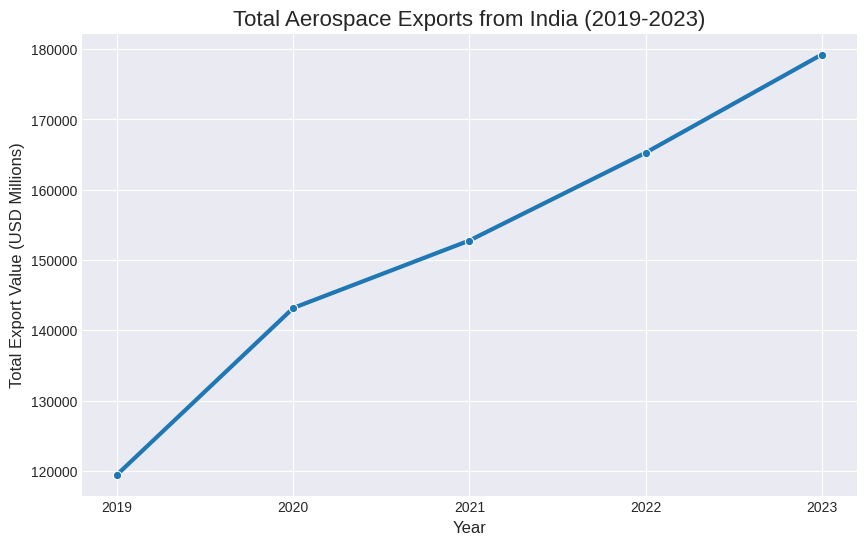


--- Plot 2: Export Value by Component (Total) ---
Data types for Plot 2: float64


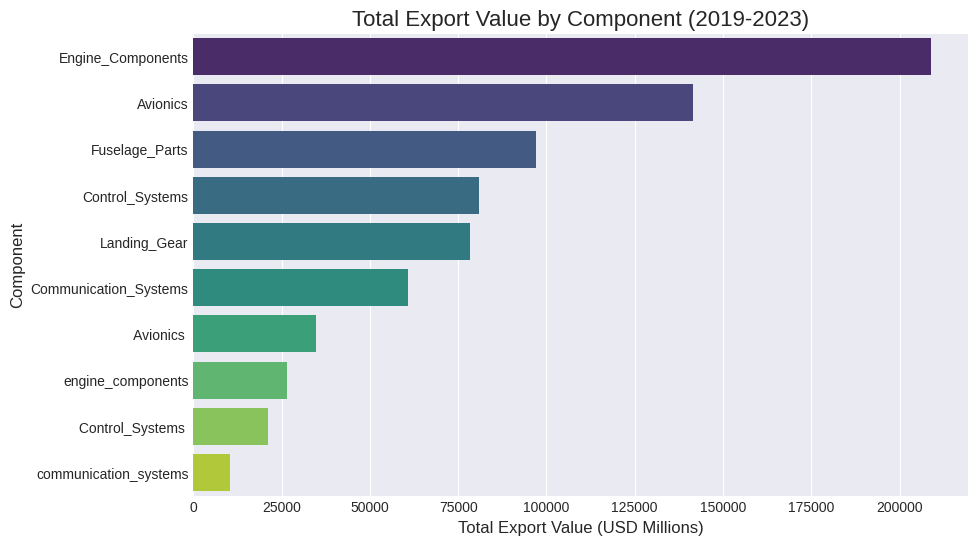


--- Plot 3: Component Export Trends Over Time ---
Data types for Plot 3: Year                          int64
ExportValue_USD_Millions    float64
Component                    object
dtype: object


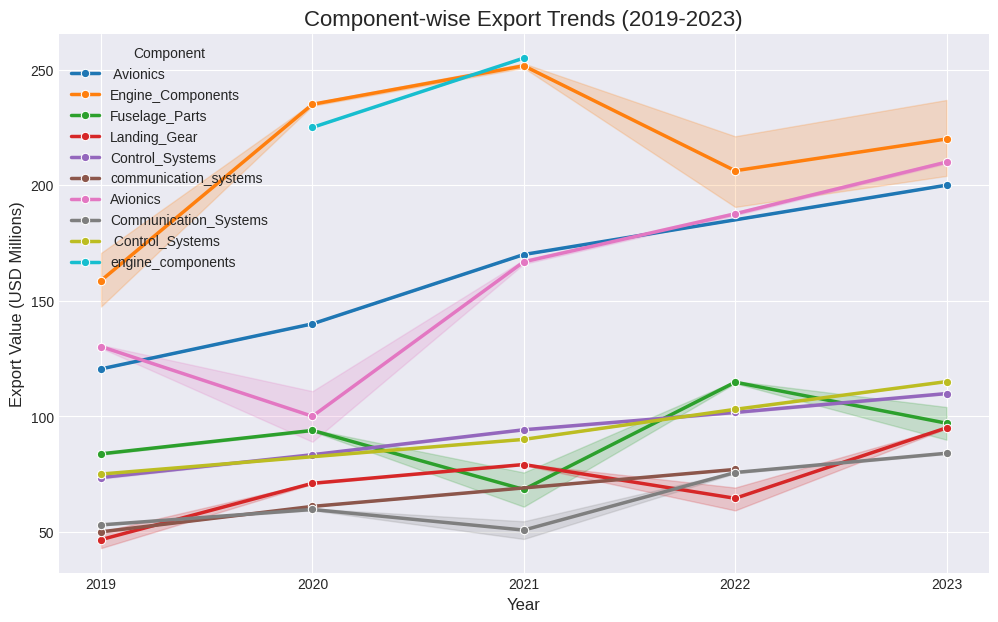


--- Plot 4: Export Share by Component (Latest Year) ---
Data types for Plot 4: ExportValue_USD_Millions    float64
Component                    object
dtype: object


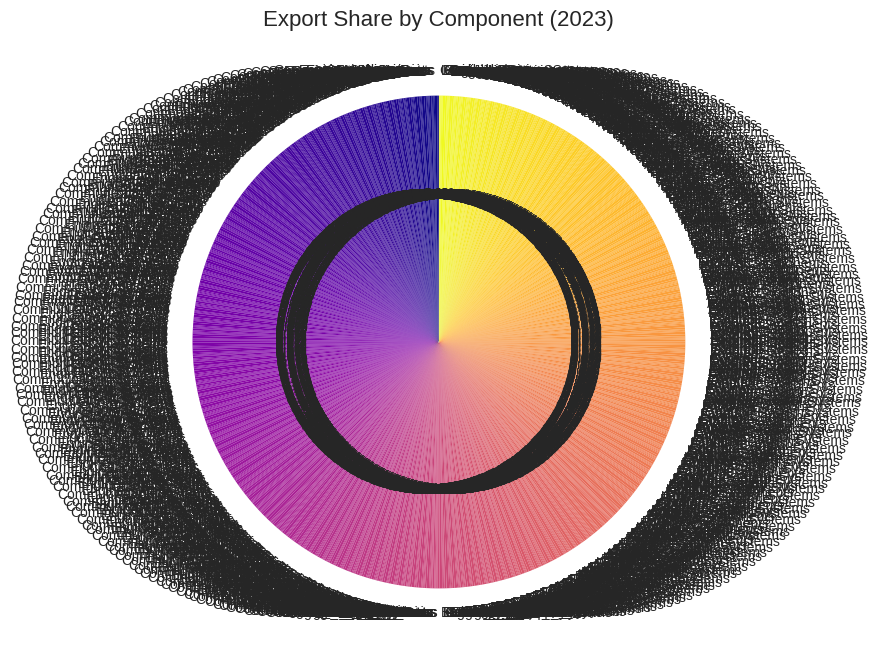


--- Plot 5: Distribution of Export Value by Component (Box Plot) ---
Data types for Plot 5: ExportValue_USD_Millions    float64
Component                    object
dtype: object


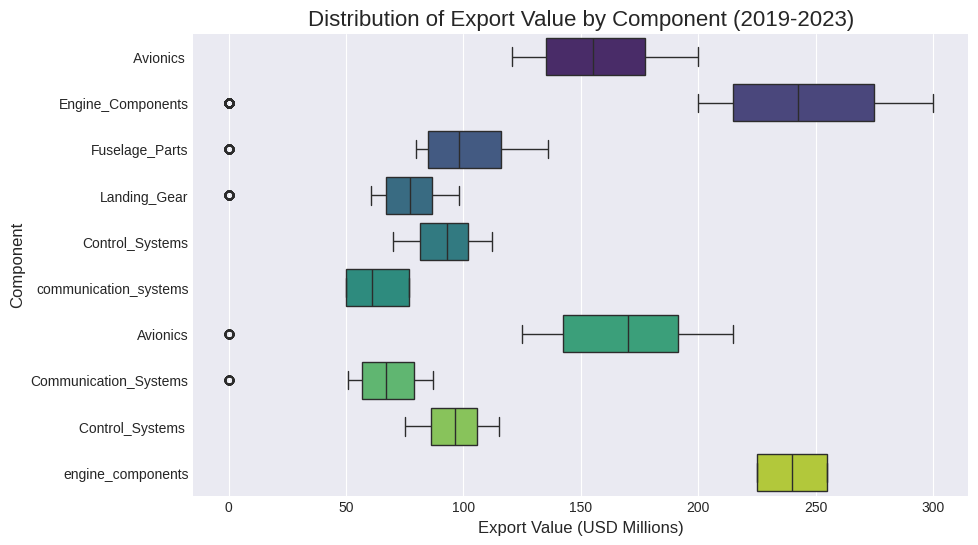


--- Plot 6: Correlation Heatmap ---
DataFrame columns: Index(['Year_Quarter', 'Component', 'ExportValue_USD_Millions',
       'Gov_Incentive_Millions', 'Year'],
      dtype='object')
Data types for Plot 6 (df_pivot): Component
 Avionics                        float64
 Control_Systems                 float64
Avionics                         float64
Communication_Systems            float64
Control_Systems                  float64
Engine_Components                float64
Fuselage_Parts                   float64
Landing_Gear                     float64
communication_systems            float64
engine_components                float64
Gov_Incentive_Total_Quarterly    float64
Total_Exports_Quarterly          float64
dtype: object
Pivot table is empty after dropping NaNs, cannot generate correlation heatmap.
EDA plots generated and saved to 'plots/' directory.

--- Starting Model Training & Evaluation ---
Model trained successfully.

--- Model Evaluation Results (on 2023 Test Data) ---
R-squa

In [234]:
# Run the main data science pipeline
run_data_science_pipeline()